<a href="https://colab.research.google.com/github/eikeschuett/IcebergShipDetection/blob/DNN_Trial_and_Error/CNN_%2Binc_angle_training_iceberg_ship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import all required libraries

In [3]:
# Libraries to access files from my drive
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.optimizers import Adam

Then, import data from Google Drive. Code adapted from [here](https://www.roelpeters.be/how-to-uploading-files-in-google-colab/).

In [26]:
# Authenticate with Google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def read_json_from_drive(file_id, file_name):
    dl = drive.CreateFile({'id': file_id})
    dl.GetContentFile(file_name)
    return pd.read_json(file_name)

df_train = read_json_from_drive('1WlrJpjbaMXEB5SrrlweDhXngBOJZHtyo', 'train.json')
print(df_train.head())

         id  ... is_iceberg
0  dfd5f913  ...          0
1  e25388fd  ...          0
2  58b2aaa0  ...          1
3  4cfc3a18  ...          0
4  271f93f4  ...          0

[5 rows x 5 columns]


Prepare the data

In [27]:
df_train["inc_angle"] = df_train["inc_angle"].replace(["na"], 0)
inc_angle = df_train["inc_angle"]
inc_angle = (inc_angle - 0)/ (90 - 0)
inc_angel = np.array(inc_angle)

# Get the labels (y-values)
labels = np.array(df_train["is_iceberg"])

# Create empty list for the images
imgs = []
for i, row in df_train.iterrows():
    # Reshape list to image
    hh  = np.reshape(row["band_1"], (75, 75))
    hv  = np.reshape(row["band_2"], (75, 75))
    b3  = hh + hv
    
    # Rescale images between 0 and 1 for faster convergence rate
    hh = (hh - hh.min())/(hh.max()-hh.min())
    hv = (hv - hv.min())/(hv.max()-hv.min())
    b3 = (b3 - b3.min())/(b3.max()-b3.min())

    # Stack the bands and append them to imgs
    imgs.append(np.dstack((hh, hv, b3)))

# Split dataset into training and test data
x_train, x_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.25, random_state=0)
x_train = np.array(x_train)
x_test = np.array(x_test)

In [29]:
x_train, x_test, inc_train, inc_test, y_train, y_test = train_test_split(imgs, inc_angle, labels, test_size=0.25, random_state=0)
x_train = np.array(x_train)
x_test = np.array(x_test)
inc_train = np.array(inc_train)


Set up DataGenerators

In [30]:
training_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')#,
    #validation_split = 0.2)

train_generator = training_datagen.flow([x_train, inc_train], y_train)#,
                                     #batch_size=64)#, 
                                     #subset = "training")

training_datagen = ImageDataGenerator(
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest')#,
    #validation_split = 0.2)



val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow([x_test, inc_test], y_test)#,
                                     #batch_size=16)#, 
                                     #subset = "training")




Set up and compile model

In [35]:
import tensorflow as tf

# Image
input_1   = tf.keras.layers.Input(shape=(75, 75, 3))
conv2d_1  = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(input_1)
#conv2d_2  = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv2d_1)
#conv2d_3  = tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv2d_2)
maxpoo_1  = tf.keras.layers.MaxPooling2D(2,2)(conv2d_1)
drop_1    = tf.keras.layers.Dropout(0.1)(maxpoo_1)

conv2d_4  = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(drop_1)
#conv2d_5  = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2d_4)
#conv2d_6  = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2d_5)
maxpoo_2  = tf.keras.layers.MaxPooling2D(2,2)(conv2d_4)
drop_2    = tf.keras.layers.Dropout(0.1)(maxpoo_2)

conv2d_7  = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(drop_2)
#conv2d_8  = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2d_7)
#conv2d_9  = tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2d_8)
maxpoo_3  = tf.keras.layers.MaxPooling2D(2,2)(conv2d_7)
drop_3    = tf.keras.layers.Dropout(0.1)(maxpoo_3)

conv2d_8  = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(drop_3)
maxpoo_4  = tf.keras.layers.MaxPooling2D(2,2)(conv2d_8)
drop_4    = tf.keras.layers.Dropout(0.1)(maxpoo_4)

flatten   = tf.keras.layers.Flatten()(drop_4)

# Layer for inclination angle
input_inc = tf.keras.layers.Input(shape=(1,))
dense_inc = tf.keras.layers.Dense(256, activation='relu')(input_inc)

# Concatenate
concat = tf.keras.layers.Concatenate()([flatten, dense_inc])
dense_1 = tf.keras.layers.Dense(512, activation='relu')(concat)
dense_2 = tf.keras.layers.Dense(256, activation='relu')(dense_1)
dense_3 = tf.keras.layers.Dense(128, activation='relu')(dense_2)

# output layer
output = tf.keras.layers.Dense(1, activation='softmax')(dense_3)

model = tf.keras.Model(inputs=[input_1, input_inc], outputs=[output])

print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, decay=0.0),
              metrics=['accuracy'])
print('Done')

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 73, 73, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 36, 36, 32)   0           conv2d_34[0][0]                  
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 36, 36, 32)   0           max_pooling2d_22[0][0]           
____________________________________________________________________________________________

Train model

In [36]:
history = model.fit(
      train_generator,
      #steps_per_epoch=10,  
      epochs=100,
      verbose=1,
      validation_data = val_generator)#,
      #validation_steps=10)

Epoch 1/100
38/38 [==============================] - 3s 53ms/step - loss: 0.6927 - accuracy: 0.4604 - val_loss: 0.6789 - val_accuracy: 0.5012
Epoch 2/100
38/38 [==============================] - 2s 48ms/step - loss: 0.6626 - accuracy: 0.4629 - val_loss: 0.6438 - val_accuracy: 0.5012
Epoch 3/100
38/38 [==============================] - 2s 49ms/step - loss: 0.6102 - accuracy: 0.4280 - val_loss: 0.5789 - val_accuracy: 0.5012
Epoch 4/100
38/38 [==============================] - 2s 49ms/step - loss: 0.5626 - accuracy: 0.4594 - val_loss: 0.5086 - val_accuracy: 0.5012
Epoch 5/100
38/38 [==============================] - 2s 49ms/step - loss: 0.5317 - accuracy: 0.4636 - val_loss: 0.5024 - val_accuracy: 0.5012
Epoch 6/100
38/38 [==============================] - 2s 56ms/step - loss: 0.5067 - accuracy: 0.4362 - val_loss: 0.5459 - val_accuracy: 0.5012
Epoch 7/100
38/38 [==============================] - 2s 48ms/step - loss: 0.5614 - accuracy: 0.4450 - val_loss: 0.4982 - val_accuracy: 0.5012
Epoch 

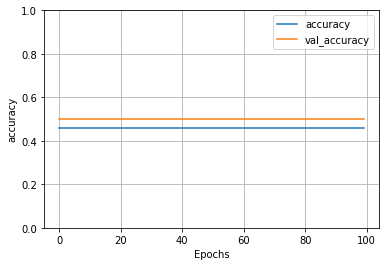

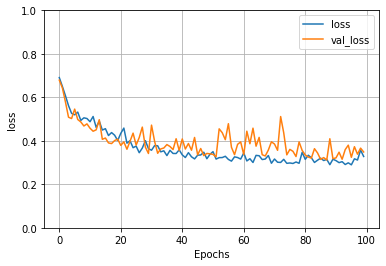

In [37]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.ylim([0,1])
  plt.grid()
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")